# Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import networkx as nx
import netwulf as wulf
import datetime as dt
import shifterator as sh
import nltk
import re
import random
import json
import community

from wordcloud import WordCloud
from networkx.readwrite import json_graph
from collections.abc import Iterable
from collections import Counter
from scipy import stats
from tfidf import term_frequency, inverse_document_frequency, tf_idf
from typing import List

from data import get_master_dict

from IPython.display import clear_output

## Load data

The course data is loaded into a pandas DataFrame. The row indices are course numbers. The most relevant columns are explained below:
- **name**: The course name.
- **department**: The department that offers the course.
- **description**: 'General course objectives' + 'Learning objectives' + 'Content' from the course page.
- **type** The course level: BSc, MSc, Ph.D etc.
- **ects** Number of points (ects) for the course.

In [2]:
courses = pd.DataFrame.from_dict(get_master_dict(), orient='index')

courses['ects'] = courses['ects'].str.replace(',', '.').astype(float)
courses['description'] = courses['description'].str.replace('\r\n', ' ')
courses['department'] = courses['department'].str.replace('\r\n', ' ')
courses['responsible'] = courses['responsible'].str.replace('\r\n', ' ')
courses['co-responsible'] = courses['co-responsible'].str.replace('\r\n', ' ')
courses['type'] = courses['type'].str.replace('Offered as a single course', '')

courses.head()

,reviews,name,description,language,ects,type,location,evaluation,responsible,department,grades,passpercent,avg,pp,avgp,qualityscore,workload,lazyscore,prerequisites,co-responsible
62434,"[{'participants': 0, 'timestamp': 'E21', '1.1'...",Applied cryptography,General course objectives The module reviews ...,English,5.0,BEng,Campus Ballerup,"7 step scale , external examiner","Henrik Tange , Ballerup Campus, Building Ball...",62 Department of Engineering Technology and D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02689,"[{'participants': 3, 'timestamp': 'E21', '1.1'...",Advanced Numerical Methods for Differential\r\...,General course objectives The use of model-ba...,English,5.0,MSc,Campus Lyngby,"7 step scale , internal examiner","Allan Peter Engsig-Karup , Lyngby Campus, Bui...",01 Department of Applied Mathematics and Comp...,"{'-3': '0', '00': '0', '02': '0', '4': '0', '7...",100.0,12.0,100.0,100.0,2.7,0.8,26.4,"02685 , A course in scientific computing for\r...",NaN
31742,"[{'participants': 25, 'timestamp': 'F21', '1.1...",Power grid analysis,General course objectives The aim of the cour...,English,5.0,MSc,Campus Lyngby,"7 step scale , internal examiner",Qiuwei Wu,31 Department of Electrical Engineering,"{'-3': '0', '00': '1', '02': '3', '4': '5', '7...",95.0,7.3,91.4,53.1,35.6,27.0,43.9,"31730 , Fundamentals of electric power\r\nengi...","Theis Bo Harild Rasmussen Enrica Raheli , Lyn..."
01527,"[{'participants': 2, 'timestamp': 'E21', '1.1'...",Graph Theory II,General course objectives The course includes...,English,5.0,"Ph.D., Professionally focussed course",Campus Lyngby,"pass / not pass , internal examiner","Carsten Thomassen , Lyngby Campus, Building 3...",01 Department of Applied Mathematics and Comp...,{},83.0,NaN,70.7,NaN,NaN,NaN,NaN,01227.01227,NaN
02326,"[{'participants': 25, 'timestamp': 'F21', '1.1...",Algorithms and Data Structures,General course objectives The course introduc...,Danish,5.0,BEng,Campus Lyngby,"7 step scale , external examiner","Eva Rotenberg , Lyngby Campus, Building 322, ...",01 Department of Applied Mathematics and Comp...,"{'-3': '17', '00': '43', '02': '20', '4': '23'...",53.0,3.5,19.0,13.5,69.5,25.2,0.6,"(01904/62506).­(02312/02314/62507) , An introd...",NaN


In [3]:
departments = courses.groupby('department').agg({'description': 'sum', 'ects': 'mean', 'avg': 'mean'})
departments.head()

,description,ects,avg
department,,,
01 Department of Applied Mathematics and Computer Science,General course objectives The use of model-ba...,5.804878,7.973864
"42 Department of Technology, Management and Economics",General course objectives The general objecti...,4.966346,9.017284
62 Department of Engineering Technology and Didactics,General course objectives The module reviews ...,6.686644,8.107955
10 Department of Physics,General course objectives To give the student...,6.300000,7.911628
11 Department of Civil Engineering,General course objectives To obtain the neces...,6.036585,7.234579


# Data exploration
We can use the course data to explore a lot of interesting properties of the courses at DTU. Here we have shown some examples of some correlations, that we find interesting.

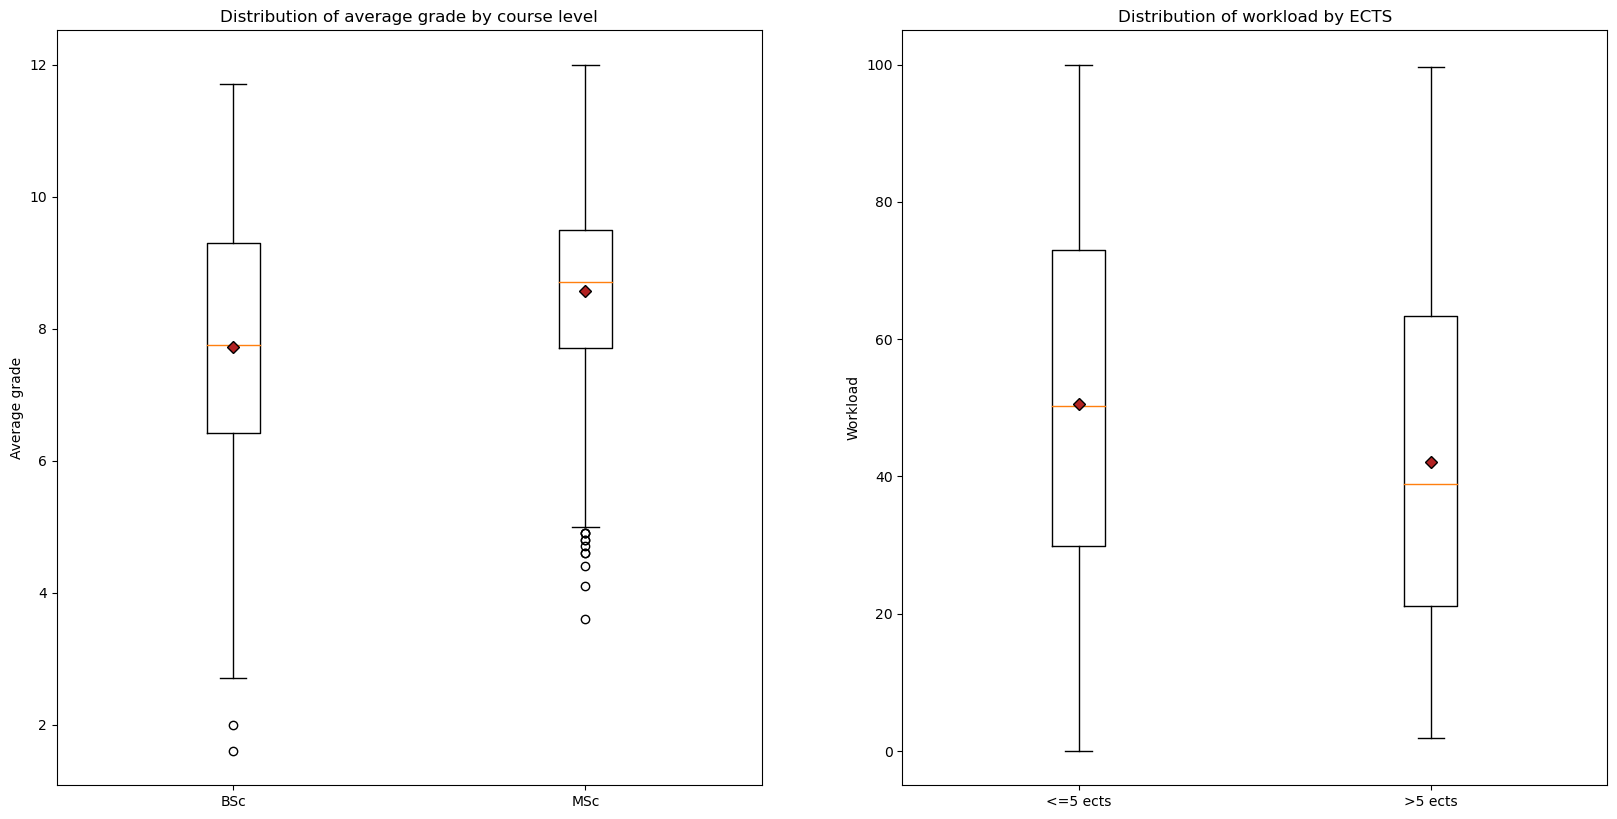

In [4]:
bsc_grades, msc_grades = courses['avg'][courses['type'] == 'BSc'].dropna(), courses['avg'][courses['type'] == 'MSc'].dropna()

meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=100)
ax1.boxplot((bsc_grades, msc_grades), showmeans=True, meanprops=meanpointprops)
ax1.set_xticklabels(('BSc', 'MSc'))
ax1.set_ylabel('Average grade')
ax1.set_title('Distribution of average grade by course level')

workloads = (courses['workload'][courses['ects'] <= 5].dropna(), courses['workload'][courses['ects'] > 5].dropna()) 

ax2.boxplot(workloads, showmeans=True, meanprops=meanpointprops)
ax2.set_xticklabels(('<=5 ects', '>5 ects'))
ax2.set_ylabel('Workload')
_ = ax2.set_title('Distribution of workload by ECTS')

# Corpus preprocessing

For the purposes of this analysis, the **text** of each course is cleaned and tokenized. The **text** of a course is the course **name** and the course **description**.

## Tokenizer

We tokenize the text by first removing all symbols and subsequently tokenizing the remaining words that at rae not stop words.

In [5]:
# Stop words are removed from the tokenized text. We get the stop words here.
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = stop_words.union(
    set(('versionsee', 'danish', 'general', 'course', 
         'learning', 'able', 'met', 'student', 'learning', 'objectives', 
         'content', 'dk', 'kurser', 'https', 'toolsapply'))
)
stop_words = [re.sub('[^a-z_-]', '', stop_word) for stop_word in stop_words]

def tokenize(text: str) -> List[str]:
    """Tokenizer function. 
    The following is removed from the tokenized text:
    Symbols, stop words.
    
    Finally, only unique words are included in the tokens (ie. no repeats)"""
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1 and 'void' not in word]
   
    return tokens

In [6]:
# The tokenized text is saved in a new column
departments['tokens'] = departments.apply(lambda row: tokenize(row['description']), axis=1)
courses['tokens'] = courses.apply(lambda row: tokenize(row['name'] + ' ' + row['description']), axis=1)
courses.head()

,reviews,name,description,language,ects,type,location,evaluation,responsible,department,...,passpercent,avg,pp,avgp,qualityscore,workload,lazyscore,prerequisites,co-responsible,tokens
62434,"[{'participants': 0, 'timestamp': 'E21', '1.1'...",Applied cryptography,General course objectives The module reviews ...,English,5.0,BEng,Campus Ballerup,"7 step scale , external examiner","Henrik Tange , Ballerup Campus, Building Ball...",62 Department of Engineering Technology and D...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[applied, cryptography, module, reviews, lates..."
02689,"[{'participants': 3, 'timestamp': 'E21', '1.1'...",Advanced Numerical Methods for Differential\r\...,General course objectives The use of model-ba...,English,5.0,MSc,Campus Lyngby,"7 step scale , internal examiner","Allan Peter Engsig-Karup , Lyngby Campus, Bui...",01 Department of Applied Mathematics and Comp...,...,100.0,12.0,100.0,100.0,2.7,0.8,26.4,"02685 , A course in scientific computing for\r...",NaN,"[advanced, numerical, methods, differential, e..."
31742,"[{'participants': 25, 'timestamp': 'F21', '1.1...",Power grid analysis,General course objectives The aim of the cour...,English,5.0,MSc,Campus Lyngby,"7 step scale , internal examiner",Qiuwei Wu,31 Department of Electrical Engineering,...,95.0,7.3,91.4,53.1,35.6,27.0,43.9,"31730 , Fundamentals of electric power\r\nengi...","Theis Bo Harild Rasmussen Enrica Raheli , Lyn...","[power, grid, analysis, aim, give, students, n..."
01527,"[{'participants': 2, 'timestamp': 'E21', '1.1'...",Graph Theory II,General course objectives The course includes...,English,5.0,"Ph.D., Professionally focussed course",Campus Lyngby,"pass / not pass , internal examiner","Carsten Thomassen , Lyngby Campus, Building 3...",01 Department of Applied Mathematics and Comp...,...,83.0,NaN,70.7,NaN,NaN,NaN,NaN,01227.01227,NaN,"[graph, theory, ii, includes, number, classica..."
02326,"[{'participants': 25, 'timestamp': 'F21', '1.1...",Algorithms and Data Structures,General course objectives The course introduc...,Danish,5.0,BEng,Campus Lyngby,"7 step scale , external examiner","Eva Rotenberg , Lyngby Campus, Building 322, ...",01 Department of Applied Mathematics and Comp...,...,53.0,3.5,19.0,13.5,69.5,25.2,0.6,"(01904/62506).­(02312/02314/62507) , An introd...",NaN,"[algorithms, data, structures, introduces, num..."


# Text analysis

## Course corpus

We consstruct the course corpus by simply extracting the tokenized text for each course. Courses that have less than 30 tokens are omitted to filter out courses that do not have proper descriptions.

In [7]:
n_tokens = courses['tokens'].apply(lambda x: len(x))

# Create a corpus wich is a dictionary of the tokenized texts
corpus = courses['tokens'][n_tokens > 30].to_dict()

### Identifying course topics
TF-IDF can be used to score terms in a document in order of how descriptive they are of the document relative to the corpus. We use TF-IDF to sort the tokens in each course description by relevancy. Next, we take the all terms that are above the 94% percentile TF-IDF. We consider the percentile a hyperparameter that can be varied according to the analysis that is conducted.

In [8]:
# Get a lookup table for the idf of each term in the corpus.
idf_lookup = inverse_document_frequency(corpus)
print(f"Number of unique terms in the corpus: {len(idf_lookup)}")

Number of unique terms in the corpus: 13911


In [9]:
course_topics = {}
course_topics_tf = {}
for course, document in corpus.items():
    tfidf, terms, tf = tf_idf(document, idf_lookup, return_tf=True)
    # sorted_indices = np.argsort(tfidf)[::-1]
    # tfidf = tfidf[sorted_indices]
    # terms = terms[sorted_indices]
    mean, sd = tfidf.mean(), tfidf.std()
    topic_indices = tfidf >= np.percentile(tfidf, 94)
    topics = terms[topic_indices]
    topics_tf = tf[topic_indices]
    if topics.size:
        course_topics[course] = topics
        course_topics_tf[course] = {topics[i]: topics_tf[i] for i in range(topics.size)}

The percentile (92.5%) was calibrated based on some familiar courses. The calibration is done qualitatively, so we simply see if the identified topics make sense. Observe that Advanced Engineering Mathematics 1 (010015) has the largest amount of topics among these examples since it is the largest course (covers the most topics). This property is desirable compared to simply choosing the top $x$ terms.

In [10]:
calibration_courses = ('01005', '02467', '02456', '46500')

for course in calibration_courses:
    print(f'Course:\t{course}')
    print(f'Topics:\t{course_topics[course]}\n')

Course:	01005
Topics:	['mathematics' 'thematic' 'linear' 'equations' 'elementary' 'functions'
 'taylor' 'integrals']

Course:	02467
Topics:	['social' 'text' 'data' 'visualization' 'metrics' 'networks' 'communities'
 'exploration' 'plots']

Course:	02456
Topics:	['deep' 'machine' 'dl' 'neural' 'feed' 'forward' 'networks' 'back'
 'propagation' 'pytorch' 'ffnn']

Course:	46500
Topics:	['probabilistic' 'wind' 'data' 'structural' 'machine' 'scada'
 'probability' 'calibrate' 'uncertainty' 'reliability' 'topic' 'submit']



### Is there a correlation between the course topics and the passing grade?

We can use the scored topics to answer the first main research question.

In [11]:
# Get the topics and their avg grade.
topic_grades = {}

for course, topics in course_topics.items():
    # If the course does not have an avg grade, we skip it.
    course_avg_grade = courses.loc[course, 'avg']
    if np.isnan(course_avg_grade):
        continue
    
    for topic in topics:
        if topic not in topic_grades:
            topic_grades[topic] = [course_avg_grade]
        else:
            topic_grades[topic].append(course_avg_grade)

Let's look at some examples.

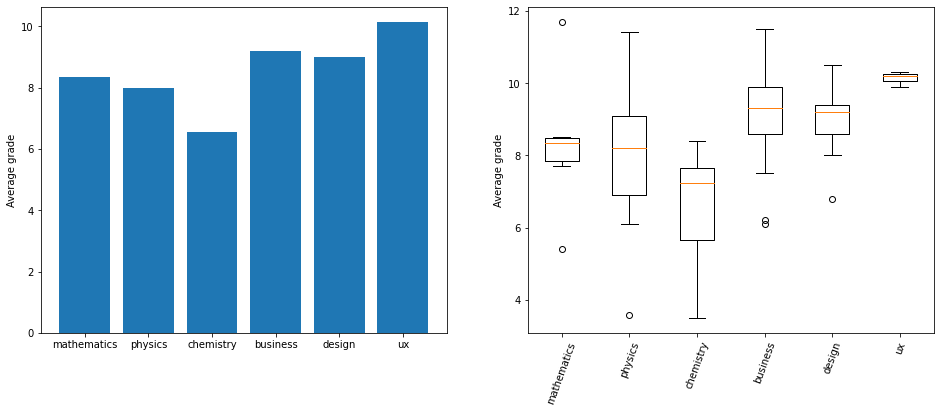

In [12]:
example_topics = ('mathematics', 'physics', 'chemistry', 'business', 'design', 'ux')
mean_avg_grades = [np.mean(topic_grades[topic]) for topic in example_topics]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(example_topics, [np.mean(topic_grades[topic]) for topic in example_topics])
plt.xticks(rotation=70)
_ = ax1.set_ylabel('Average grade')

ax2.boxplot([topic_grades[topic] for topic in example_topics])
ax2.set_xticklabels(example_topics, rotation=70)
_ = ax2.set_ylabel('Average grade')

To identify the main topics the topics that appear in less than 10 courses are filtered out.

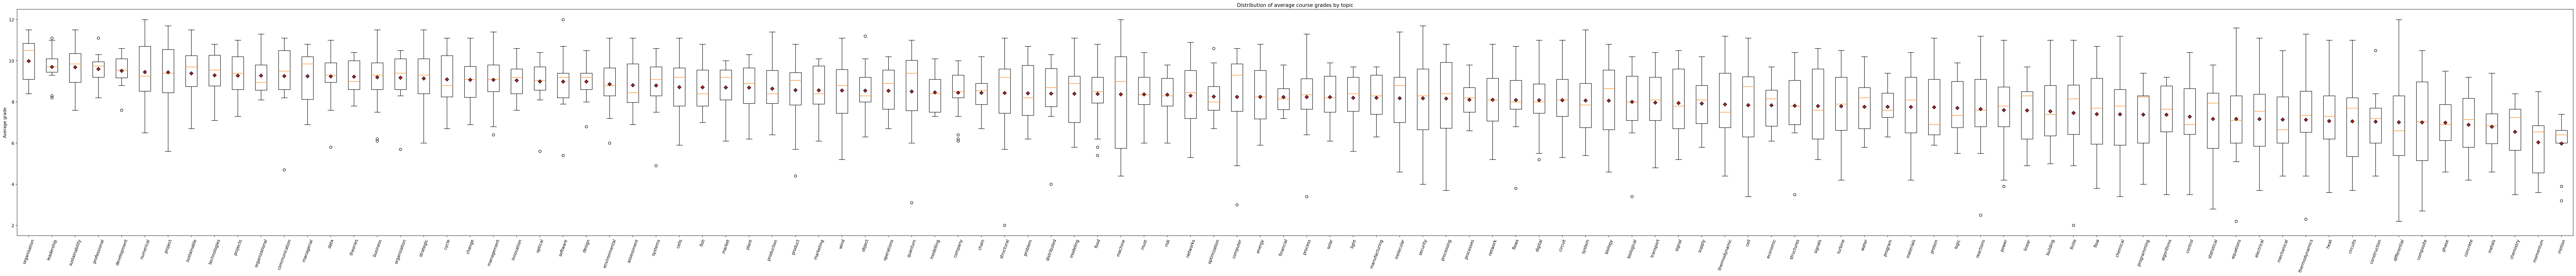

In [13]:
# Filter topics that occur in less than 10 courses
min_appearances = 10

topic_grades_filtered = {topic: avg_grades for topic, avg_grades in topic_grades.items() if len(avg_grades) >= min_appearances}
topic_arr = np.array(list(topic_grades_filtered.keys()))
topic_avg_grades = list(topic_grades_filtered.values())
topic_mean_avg_grades = np.array([np.mean(avg_grades) for avg_grades in topic_avg_grades])
sorted_indices = np.argsort(topic_mean_avg_grades)[::-1]

topic_arr = topic_arr[sorted_indices]
topic_avg_grades = [topic_avg_grades[index] for index in sorted_indices]
topic_mean_avg_grades = topic_mean_avg_grades[sorted_indices]

meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

fig, ax = plt.subplots(1, 1, figsize=(topic_arr.size * 1, 10), dpi=200)

ax.boxplot(topic_avg_grades, showmeans=True, meanprops=meanpointprops)
ax.set_xticklabels(topic_arr, rotation=70)
ax.set_ylabel('Average grade')
_ = ax.set_title('Distribution of average course grades by topic')
plt.savefig('grades_by_topic')

## Department corpus
We can also make a corpus of all course descriptions in a department. We can use TF-IDF to score the terms and create some very nice looking wordclouds, that visualize what each department is about.

In [14]:
# Create a corpus wich is a dictionary of the tokenized texts
corpus = departments['tokens'].to_dict()

In [15]:
idf_lookup = inverse_document_frequency(corpus)

### Wordclouds

In [16]:
# # Generate a word cloud image
# for department, document in corpus.items():
#     tfidf, terms = tf_idf(document, idf_lookup)
#     wc = WordCloud(background_color='white', width=1600, height=800).generate_from_frequencies({term: w for w, term in zip(tfidf, terms)})
    
#     fig, ax = plt.subplots(1, 1, figsize=(18, 9))
#     fig.suptitle(f'{department}', fontsize='xx-large')
#     ax.imshow(wc, interpolation='bilinear')
#     ax.axis('off')
#     plt.show()

# Network analysis

In [17]:
# adjacency_dict = {}

# n_courses = len(course_topics)
# for i, (course, topics) in enumerate(course_topics.items()):
#     edges = {}

#     topics_set = set(topics)
#     for other_course, other_topics in course_topics.items():
#         if course == other_course:
#             continue
        
#         common_topics = topics_set.intersection(other_topics)
#         if common_topics:
#             edges[other_course] = {'weight': sum([course_topics_tf[course][topic] * course_topics_tf[other_course][topic]
#                                                  for topic in common_topics])}
    
#     adjacency_dict[course] = edges
    
#     clear_output(wait=True)
#     print(i/n_courses)

# G = nx.Graph(adjacency_dict)

# with open('course_graph.json', 'w') as outfile:
#     json.dump(json_graph.node_link_data(G), outfile, indent=8)

In [18]:
with open('course_graph.json') as f:
    G = json_graph.node_link_graph(json.load(f))

In [19]:
n_departments = courses['department'].nunique()

cm = plt.get_cmap('tab20b')
color_linspace = np.linspace(0, 1, num=n_departments)
department_cmap = {department: tuple((np.array(cm(color_linspace[i]))[:3] * 255).astype(int)) for i, department in enumerate(courses['department'].unique())}
department_cmap = {department: (rgb, "#{0:02x}{1:02x}{2:02x}".format(*rgb)) for department, rgb in department_cmap.items()}

for k, v in G.nodes(data=True):
    v['group'] = department_cmap[courses.loc[k, 'department']][1]

In [20]:
config = {'zoom': 0.78,
 'node_charge': -45,
 'node_gravity': 0.13253538995726497,
 'link_distance': 50,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#79aaa0',
 'node_stroke_color': '#373737',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': True,
 'node_size': 10.729333600427351,
 'node_stroke_width': 1,
 'node_size_variation': 0.3155548878205128,
 'link_color': '#575656',
 'link_width': 0.7037790798611111,
 'link_alpha': 0.49720775462962963,
 'link_width_variation': 0.39760616987179487,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

stylized_network, config = wulf.visualize(G, config=config, is_test=False, plot_in_cell_below=False)

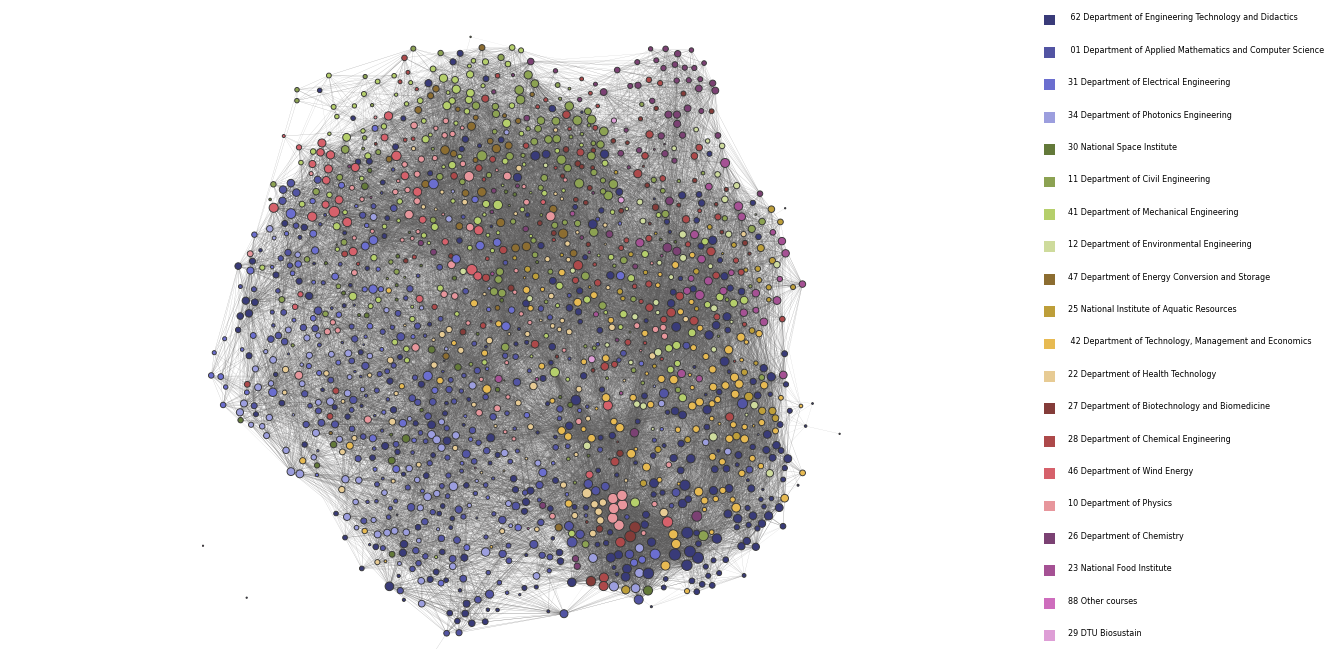

In [21]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(18, 9)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0, width_ratios=(.8, .2))
axs = subfig2.subplots(n_departments, 2)

for i, (department, (rgb, _)) in enumerate(department_cmap.items()):
    ax_color, ax_text = axs[i]
    ax_text.text(0, 0.5, department, dict(size=8))
    ax_color.imshow([[np.array(rgb)/255]])
    ax_text.axis('off')
    ax_color.axis('off')

ax = subfig1.subplots(1, 1)
fig, ax = wulf.draw_netwulf(stylized_network, fig=subfig1, ax=ax)
plt.show()

## Analysis of modularity

In [22]:
department_partition = {}
for k, v in G.nodes(data=True):
    department = courses.loc[k, 'department']
    if department not in department_partition:
        department_partition[department] = set([k])
    else:
        department_partition[department].add(k)
department_partition = list(department_partition.values())

modularity = nx.algorithms.community.modularity(G, department_partition)

RG = G.copy()
RG = nx.double_edge_swap(RG, nswap=1000, max_tries=10000)

department_partition = {}
for k, v in RG.nodes(data=True):
    department = courses.loc[k, 'department']
    if department not in department_partition:
        department_partition[department] = set([k])
    else:
        department_partition[department].add(k)
department_partition = list(department_partition.values())

modularity_random = nx.algorithms.community.modularity(RG, department_partition)

print(f'Modularity of the true graph:\t\t{modularity}\nModularity of the shuffled graph:\t{modularity_random}')

Modularity of the true graph:		0.23924180790985858
Modularity of the shuffled graph:	-0.011903003528649233


## Community detection

In [23]:
partition = nx.algorithms.community.louvain_communities(G, resolution=1, threshold=1e-07, seed=1510)

In [24]:
cleaned_partition = []
other_community = set()
for community in partition:
    if len(community) > 5:
        cleaned_partition.append(community)
    else:
        other_community = other_community.union(community)

cleaned_partition.append(other_community)
partition = cleaned_partition

In [25]:
n_communities = len(partition)

cm = plt.get_cmap('tab20b')
color_linspace = np.linspace(0, 1, num=n_communities)
community_cmap = {i: tuple((np.array(cm(color_linspace[i]))[:3] * 255).astype(int)) for i in range(n_communities)}
community_cmap = {i: (rgb, "#{0:02x}{1:02x}{2:02x}".format(*rgb)) for i, rgb in community_cmap.items()}

for k, v in G.nodes(data=True):
    for i, community in enumerate(partition):
        if k in community:
            break
    v['group'] = community_cmap[i][1]

In [26]:
stylized_network, config = wulf.visualize(G, config=config, is_test=False, plot_in_cell_below=False)

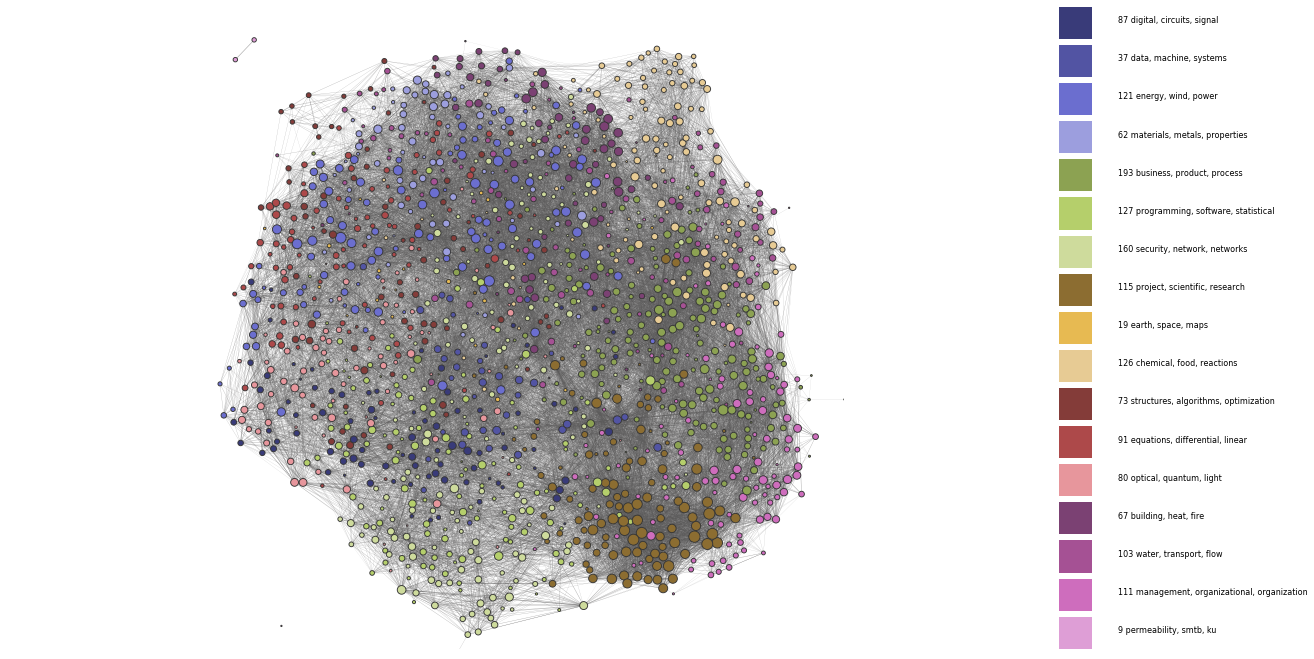

In [27]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(18, 9)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0, width_ratios=(.8, .2))
axs = subfig2.subplots(n_communities, 2)

for i, (rgb, _) in community_cmap.items():
    community = partition[i]
    community_topics = np.array([])
    for course in community:
        community_topics = np.concatenate((community_topics, course_topics[course]))
    topics, counts = np.unique(community_topics, return_counts=True)
    if topics.size:
        sorted_indices = np.argsort(counts)[::-1]
        topics_top3 = list(topics[sorted_indices[:3]])
    ax_color, ax_text = axs[i]
    ax_text.text(0, 0.5, f"{len(community)} {', '.join(topics_top3)}" , dict(size=8))
    ax_color.imshow([[np.array(rgb)/255]])
    ax_text.axis('off')
    ax_color.axis('off')
    # DEBUG
    if len(community) == 1:
        offender = list(community)[0]
        print(offender)
        print(courses.loc[offender, 'name'])
        print(', '.join(topics_top3))

ax = subfig1.subplots(1, 1)
fig, ax = wulf.draw_netwulf(stylized_network, fig=subfig2, ax=ax)
plt.show()

## Jaccard similarity

In [28]:
department2label = {department: index for index, department in enumerate(courses['department'].unique())}

In [29]:
Z = []
Q = []
for index, community in enumerate(partition):
    for course in community:
        Z.append(index)
        Q.append(department2label[courses.loc[course, 'department']])
Z = np.array(Z)
Q = np.array(Q)

N = Z.size
K, M = max(Z) + 1, max(Q) + 1
# Joint count matrix
nkm = np.zeros((max(Z) + 1, max(Q) + 1))
for z in range(K):
    for q in range(M):
        nkm[z, q] = np.sum((Z == z) & (Q == q))
nZ = nkm.sum(1)
nQ = nkm.sum(0)

In [30]:
S = np.sum(nkm * (nkm - 1) / 2)
D = N * (N - 1) / 2 - np.sum(nZ * (nZ - 1) / 2) - np.sum(nQ * (nQ - 1) / 2) + S
J = S / (.5 * N * (N - 1) - D)
J

0.0861854987727185